## Example curve prediction script
In this notebook we will try to predict the function coefficients.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

from generate_TF import GenerateTF

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorchClassifiers import Net


In [13]:
# Load the data
df21 = pd.read_pickle('./data/tf-measurement-2021.pkl')
# print(df21.head())
df22 = pd.read_pickle('./data/tf-measurement-2022.pkl')
# print(df22.head())
df = pd.concat([df21, df22])
print(df.head())

                                                        y  \
3B2_21  [-21.777909296765575, -15.057012209125634, -14...   
4B1_21  [-16.549652269096566, -20.01969655997585, -20....   
1B1_21  [-20.2673641620488, -19.779742221907256, -18.4...   
5B2_21  [-13.816465626241573, -19.706971066659623, -25...   
3B1_21  [-14.487696517960305, -27.50301068354199, -27....   

                                                        x  
3B2_21  [-1619443.359375, -1614550.78125, -1609658.203...  
4B1_21  [-1619443.359375, -1614550.78125, -1609658.203...  
1B1_21  [-1619443.359375, -1614550.78125, -1609658.203...  
5B2_21  [-1619443.359375, -1614550.78125, -1609658.203...  
3B1_21  [-1619443.359375, -1614550.78125, -1609658.203...  


In [34]:
df.loc['3B2_21'].y

array([-2.17779093e+01, -1.50570122e+01, -1.41341856e+01, -1.91233004e+01,
       -1.72589636e+01, -1.34814954e+01, -2.11783870e+01, -1.08961474e+01,
       -2.69381325e-01, -2.28826349e+00, -1.13478705e+01, -2.01095315e+01,
       -2.00727475e+01, -1.82893319e+01, -2.64740211e+01, -3.29216883e+01,
       -3.49739256e+01, -1.75376559e+01, -1.93519500e+01, -2.03693290e+01,
       -2.01439443e+01, -1.17486731e+01, -1.90845953e+01, -2.28867579e+01,
       -2.07671359e+01, -2.30170726e+01, -2.02550871e+01, -1.69078477e+01,
       -1.71679592e+01, -1.75826232e+01, -1.82159438e+01, -1.29721829e+01,
       -1.82189518e+01, -1.34129422e+01, -1.31247735e+01, -2.08729696e+01,
       -2.86945875e+01, -2.95395298e+01, -1.99068363e+01, -2.61461745e+01,
       -1.92018521e+01, -2.28483689e+01, -1.57914413e+01, -1.54612281e+01,
       -1.83476631e+01, -2.00798372e+01, -1.69546512e+01, -1.87384333e+01,
       -1.75885707e+01, -1.93133735e+01, -2.39454338e+01, -2.34230373e+01,
       -1.79171199e+01, -

In [29]:
tempdf = pd.read_pickle('./data/new-transfer-functions-82000.pkl')

phi_encoder = preprocessing.LabelEncoder()
phi_encoder.fit(tempdf['phi'])
print(phi_encoder.classes_)

gain_encoder = preprocessing.LabelEncoder()
gain_encoder.fit(tempdf['g_oo'])
print(gain_encoder.classes_)

del tempdf

[-20. -19. -18. -17. -16. -15. -14. -13. -12. -11. -10.  -9.  -8.  -7.
  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.   4.   5.   6.   7.
   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.  20.]
[0.001      0.0010884  0.00118461 0.00128933 0.0014033  0.00152735
 0.00166237 0.00180932 0.00196926 0.00214334 0.00233281 0.00253902
 0.00276347 0.00300776 0.00327364 0.00356302 0.00387799 0.00422079
 0.00459391 0.005     ]


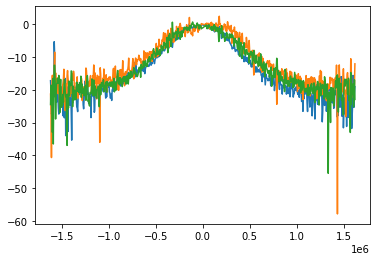

In [21]:
# Visualize the data
for index, row in df.sample(n=3).iterrows():
    y = row['y']
    x = row['x']
    plt.plot(x, y)
plt.show()

In [22]:
values = np.zeros((len(df), len(df.iloc[0]['y'])), dtype=np.float32)
# print(values.shape)
index = 0
for _, row in df.iterrows():
    values[index, :] = row['y']
    index += 1

data_scaler = preprocessing.StandardScaler().fit(values)


In [23]:
# Initialize model, loss function and optimizer
# This is for the first parameter: phi
n_inputs = values.shape[1]
# we will build one model per output target
n_outputs = 41
model1 = Net(n_inputs, n_outputs, name='phase_classifier', activation_func=F.gelu,
             hidden_1=500, hidden_2=200, hidden_3=0,
             avg_pool=(6, 6), trim_edges=135, verbose=1,
             with_batch_norm=True, save_best=True)
print(model1)

# specify loss function (regression)
criterion = nn.NLLLoss()

# specify optimizer
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.005)


Net(
  (center): ConstantPad1d(padding=(-135, -135), value=0)
  (pool1): AvgPool1d(kernel_size=(6,), stride=(6,), padding=(0,))
  (fc1): Linear(in_features=65, out_features=500, bias=True)
  (batch_norm1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=500, out_features=200, bias=True)
  (batch_norm2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=200, out_features=41, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [24]:
# Initialize model, loss function and optimizer
# This is for the second parameter: g_oo

n_inputs = values.shape[1]
# we will build one model per output target
n_outputs = 20

model2 = Net(n_inputs, n_outputs, name='gain_classifier', activation_func=F.gelu,
             hidden_1=420, hidden_2=350, hidden_3=0,
             avg_pool=(4,4), trim_edges=120, save_best=True)
print(model2)

# specify loss function (regression)
criterion = nn.NLLLoss()

# specify optimizer
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.005)


Net(
  (center): ConstantPad1d(padding=(-120, -120), value=0)
  (pool1): AvgPool1d(kernel_size=(4,), stride=(4,), padding=(0,))
  (fc1): Linear(in_features=105, out_features=420, bias=True)
  (fc2): Linear(in_features=420, out_features=350, bias=True)
  (fc3): Linear(in_features=350, out_features=20, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [25]:
# load model with the highest accuracy
# model1.load_state_dict(torch.load('models/model1.pt'))
# model2.load_state_dict(torch.load('models/model2.pt'))

model1.load(optimizer=optimizer1, filename='models/new_phase_classifier-acc62.pt')
model2.load(optimizer=optimizer2, filename='models/new_gain_classifier-acc99.pt')


In [26]:
from generate_TF import GenerateTF
import torch
import torch.nn.functional as F


def curve_fit_deluxe(func, x, sample, trim_edges=0, kernel_size=1, stride=1, **kwargs):
    # center crop sample
    if trim_edges > 0:
        x, sample = x[trim_edges:-trim_edges], sample[trim_edges:-trim_edges]
    # convert to tensor for average pooling
    x = torch.tensor(x).view(1, -1)
    sample = torch.tensor(sample).view(1, -1)
    # average pool sample
    x = F.avg_pool1d(x, kernel_size=kernel_size, stride=stride).ravel().numpy()
    sample = F.avg_pool1d(sample, kernel_size=kernel_size, stride=stride).ravel().numpy()
    return curve_fit(func, x, sample, **kwargs)


This region is to use gradio and visualize predictions

/tmp/ipykernel_194703/2732432847.py:60: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


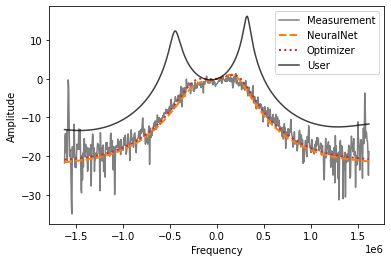

In [45]:

def classify(measurement_id, phase, gain):

    x = df.loc[measurement_id].x
    y = df.loc[measurement_id].y
    phase, gain = float(phase), float(gain)

    table = []

    gen_tf_noise = GenerateTF(fb_attn_index=3, with_noise=True)

    gen_tf_no_noise = GenerateTF(fb_attn_index=3, with_noise=False)

    # I get one input with given phase, gain from X_validate or y_validate
    y_scaled = torch.tensor(data_scaler.transform([y]), dtype=torch.float32)

    # phase_encoded = phi_encoder.transform([phase])
    # gain_encoded = gain_encoder.transform([gain])

    # I make predictions with models + optimizer
    with torch.no_grad():
        model1.eval()
        model2.eval()
        pred_phase = model1(torch.atleast_2d(y_scaled))
        pred_gain = model2(torch.atleast_2d(y_scaled))

    # Extract top category
    _, pred_phase = torch.exp(pred_phase).topk(1, dim=1)
    _, pred_gain = torch.exp(pred_gain).topk(1, dim=1)

    # Get original value
    pred_phase = phi_encoder.inverse_transform(pred_phase.ravel().numpy())[0]
    pred_gain = gain_encoder.inverse_transform(pred_gain.ravel().numpy())[0]

    # Get optimizers results
    (opt_phase, opt_gain), _ = curve_fit_deluxe(gen_tf_no_noise, x, y, trim_edges=130,
                                                kernel_size=4, stride=1,
                                                bounds=([-20, 0.001], [20, 0.005]), method='trf')

    # I add them to the table
    table.append(['phase', float(np.round(pred_phase, 2)), float(np.round(opt_phase, 2))])
    table.append(['gain', float(np.round(pred_gain, 4)), float(np.round(opt_gain, 4))])

    # I plot them
    fig = plt.figure()
    # p = plt.plot(x, gen_tf_no_noise(x, phase, gain), label=f'True', ls='-', color='black')
    plt.plot(x, y, label=f'Measurement', ls='-', color='black', alpha=0.5)
    plt.plot(x, gen_tf_no_noise(x, pred_phase, pred_gain), label=f'NeuralNet',
             ls='--', color='tab:orange', lw=2)
    plt.plot(x, gen_tf_no_noise(x, opt_phase, opt_gain), label=f'Optimizer',
             ls=':', color='tab:red', lw=2)
    plt.plot(x, gen_tf_no_noise(x, phase, gain), label=f'User',
             ls='-', color='black', alpha=0.75)
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.legend()
    # print(table.get_string())
    return fig, table

fig, table = classify('3B2_21', -20, 0.005)
fig.show()
# print(table)

# return: an array (with the predicted/ real values) + a figure with the ploted lines

In [46]:
import gradio as gr

# print(gain_encoder.classes_.astype(str).tolist())
# build the gradio interface
dropdown = gr.Dropdown(choices=list(df.index.values), label='Measurement')
slider = gr.Slider(label=f'Phase', minimum=-20., maximum=20., step=1.)
dropdown_gain = gr.Dropdown(label='Gain',
                            choices=gain_encoder.classes_.astype(str).tolist(),
                            type='value')
interface = gr.Interface(fn=classify,
                         inputs=[
                             dropdown,
                             slider,
                             dropdown_gain
                         ],
                         outputs=[
                             gr.Plot(label='Graphical Evaluation'),
                             # gr.Textbox(lines=5),
                             gr.DataFrame(label='Numerical Evaluation',
                                          headers=['Param', 'NeuralNet', 'Optimizer'],
                                          datatype=['str', 'number', 'number'],
                                          row_count=2, col_count=(3, 'fixed'))
                         ],
                         interpretation="default",
                         )

interface.launch(debug=False)

Running on local URL:  http://127.0.0.1:7861/

To create a public link, set `share=True` in `launch()`.


(<gradio.routes.App at 0x7f20b06639d0>, 'http://127.0.0.1:7861/', None)